In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import json
import datetime

import numpy as np
import pandas as pd

In [3]:
# - Who had the largest increase in followers
# - what were the most shared hashtags?
# - who were the most retweeted users?
# - who were the most mentioned users?
# - what was the most shared link?

In [4]:
time_format = "%a %b %d %H:%M:%S +0000 %Y"

In [5]:
def str_to_json(json_str):    
    try:
        tweet = json.loads(json_str)
        return tweet
    except ValueError as ve:
        return None
    
def tweet_to_hashtag(tweet):
    return [(ht["text"].lower(), 1) for ht in tweet["entities"]["hashtags"]]

def t_to_d(t):
    return datetime.datetime.strptime(t["created_at"], time_format)

def tweet_to_entity(tweet, entity, field="text"):
    return [(ht[field], 1) for ht in tweet["entities"][entity]]

def delta_followers(l):
    filtered_l = [x for x in l if x[1] >= 20]
    mult = (0, 0)
    if ( len(filtered_l) > 1 ):
        sorted_samples = sorted(filtered_l, key=lambda x: x[0])
        first_sample = sorted_samples[0][1]
        last_sample = sorted_samples[-1][1]

        diff = last_sample - first_sample
        mult = (diff / (first_sample + 1), diff)

    return mult

In [6]:
# rdd = sc.textFile("/scratch/clb617/data/wri/wri_2018/data/community_filtered.json.gz")
rdd = sc.textFile("wri/2018_community_filtered")
tweets_ = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)
tweets = tweets_.map(lambda t: (t["id"], t)).reduceByKey(lambda l, r: l).map(lambda tup: tup[1]).cache()

#################### Tweet Count ####################
188675
#################### User Count ####################
17752
#################### Loudest Users ####################
('OlumideIDOWU', 4331)
('RichardMunang', 2115)
('GlobalLF', 1744)
('estherclimate', 1450)
('ClimateWed', 1440)
('EWestaway', 787)
('msimire', 698)
('wandieville', 665)
('andyheald', 596)
('africa_ci', 492)
('johnagboolao1', 450)
('environewsng', 450)
('BBCAfrica', 394)
('mnarbs', 388)
('mpi_digital', 374)
('ReutersAfrica', 368)
('ICRAF', 356)
('Hydr_Mwangi', 353)
('RichardStanleyM', 348)
('JasiriAfricaKE', 345)
#################### Most Used Hashtags ####################
('climatechange', 5865)
('africa', 4407)
('glfnairobi2018', 3302)
('climateaction', 2482)
('gcas2018', 1960)
('agriculture', 1333)
('youth', 1297)
('forests', 1252)
('parisagreement', 1234)
('wwweek', 1206)
('sdgs', 1160)
('thinklandscape', 1134)
('climate', 1081)
('sb48bangkok', 916)
('forest', 890)
('water', 813)
('nigeria', 792)
('didyouknow',

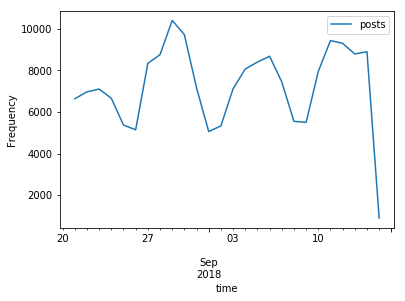

In [7]:
local_map = {}

print("#" * 20, "Tweet Count", "#" * 20)
count = tweets.count()
print(count)
local_map["count"] = count


users = tweets.map(lambda t: (t["user"]["screen_name"], 1)).reduceByKey(lambda l,r: l+r)
users_ = users.collect()
print("#" * 20, "User Count", "#" * 20)
print(len(users_))
users_sorted = sorted(users_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Loudest Users", "#" * 20)
for u in users_sorted[:20]:
    print(u)
local_map["users"] = users_sorted

hashtags = tweets.flatMap(tweet_to_hashtag).reduceByKey(lambda x, y: x+y)
hashtags_ = hashtags.collect()
hashtags_sorted = sorted(hashtags_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Used Hashtags", "#" * 20)
for ht in hashtags_sorted[:20]:
    print(ht)
local_map["hashtags"] = hashtags_sorted


entities = tweets.flatMap(lambda x: tweet_to_entity(x, "urls", "expanded_url")).reduceByKey(lambda x, y: x+y)
entities_ = entities.collect()
entities_sorted = sorted(entities_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Shared URLs", "#" * 20)
for e in entities_sorted[:20]:
    print(e)
local_map["urls"] = entities_sorted

entities = tweets.flatMap(lambda x: tweet_to_entity(x, "user_mentions", "screen_name")).map(lambda x: (x[0].lower(), x[1])).reduceByKey(lambda x, y: x+y)
entities_ = entities.collect()
entities_sorted = sorted(entities_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Mentioned", "#" * 20)
for e in entities_sorted[:20]:
    print(e)
local_map["mentions"] = entities_sorted

retweeted_users = tweets.filter(lambda t: "retweeted_status" in t).\
    map(lambda t: t["retweeted_status"]).\
    map(lambda t: (t["user"]["screen_name"].lower(), 1))
retweeted_users_ = retweeted_users.reduceByKey(lambda x, y: x + y).collect()
retweeted_users_sorted = sorted(retweeted_users_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Retweeted", "#" * 20)
for e in retweeted_users_sorted[:20]:
    print(e)
local_map["retweet"] = retweeted_users_sorted

users = tweets.map(lambda t: (t["user"]["screen_name"], [(t_to_d(t), t["user"]["followers_count"])]))
user_followers = users.reduceByKey(lambda l, r: l + r).mapValues(delta_followers).collect()
user_followers_sorted = sorted(user_followers, key=lambda x: x[1][0], reverse=True)
print("#" * 20, "Greatest Follower Gain by Multiple", "#" * 20)
for e in user_followers_sorted[:20]:
    print(e)
local_map["followers"] = user_followers

user_followers_sorted = sorted(user_followers, key=lambda x: x[1][1], reverse=True)
print("#" * 20, "Greatest Follower Gain by Volume", "#" * 20)
for e in user_followers_sorted[:20]:
    print(e)

post_times = tweets.map(lambda t: (t_to_d(t), 1)).reduceByKey(lambda l, r: l+r).collect()
df = pd.DataFrame(post_times, columns=["time", "posts"])
df.index = df.time
df.resample("D").sum().plot()
plt.ylabel("Frequency")
plt.show()

local_map["temporal"] = df



In [8]:
# tgs = ["ethiopialiveupd", "idziedzorm", "mgavner2", "gnbug1", "colonjuwonilo", "p2pafghanistan", "annabel04163592", "musaotienoongao", "zenhuman", "collect86", "30x30ffl", "afdb_group", "_africanunion", "olumideidowu"]
tgs = [
    # GLF Social Media Toolkit Users
    "globallf",
    "unenvironment",
    "cifor",
    "icraf",
    "fta_cgiar",
    "worldresources",
    "giz_gmbh",
    "forests4africa",
    "faoforestry",
    "worldbank",
    "ilri",
    "wangarimaathai",
    "greenbeltmovmnt",
    "ypard",
    "uonbi",
    "wwf",
    "iucn",
    "usaid",
    "idh_buzz",
    "eriksolheim",
    "afr100_official",
    "africa_ci",
    "awf_official",
    "ciat_",
    "rockydawuni",

    # Greatest follower gain
    "thulimadonsela3",
    "mthulincube",
    "governorkibwana",
    "omojuwa",
    "gcas2018",
    "unfccc",
    "_africanunion",
    
    # Others of interest
    "30x30ffl", 
    "afdb_group", 
    "olumideidowu",
]
target_users = {x:None for x in tgs}

for target_user in target_users.keys():
    timed_followers = tweets.filter(lambda t: t["user"]["screen_name"].lower() == target_user).\
        map(lambda t: (datetime.datetime.strptime(t["created_at"], time_format), t["user"]["followers_count"])).\
        collect()
        
    target_users[target_user] = timed_followers

In [9]:
target_users_df = {}

for target_user, timed_followers in target_users.items():
    df = pd.DataFrame(timed_followers, columns=["time", "followers"])
    df.index = pd.to_datetime(df.time)
    
    target_users_df[target_user] = df

In [10]:
dfs = [df.drop_duplicates().resample("D").pad().rename(columns={"followers": u}) for u, df in target_users_df.items()]

In [11]:
first = None
for df in dfs:
    if ( first is None ):
        first = df.copy()
    else:
        first = first.join(df[df.columns[1]], how="outer")

In [12]:
left = None
for df in dfs:
    if ( left is None ):
        left = df
    else:
        left = left.join(df, rsuffix="_", how="outer")
        
for u in target_users_df.keys():
    left[u + "_norm"] = (left[u] - left[u].min()) / (left[u].max() - left[u].min())

/home/clb617/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f08f4256400> has a label of '_africanunion_norm' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


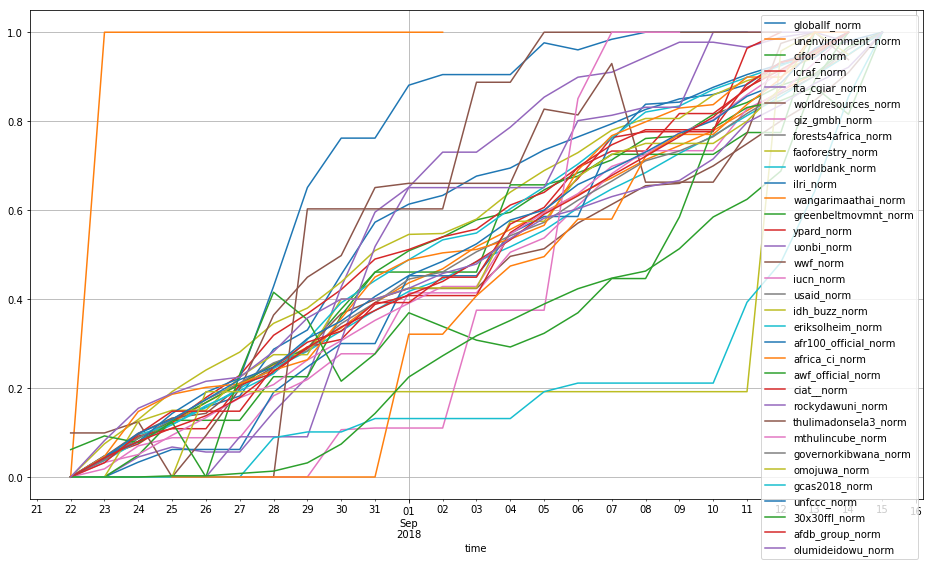

In [13]:
fig = plt.figure(figsize=(16,9))

ax = plt.subplot(1,1, 1)
left[[x + "_norm" for x in target_users.keys()]].plot(ax=ax)
# left["olumideidowu"].plot(ax=ax)

# ax.set_yscale("log")

plt.grid()
plt.show()

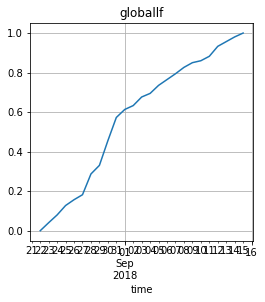

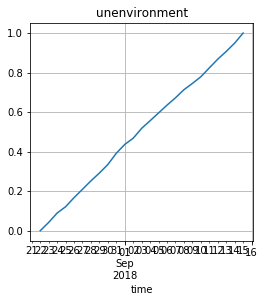

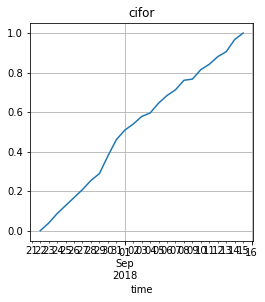

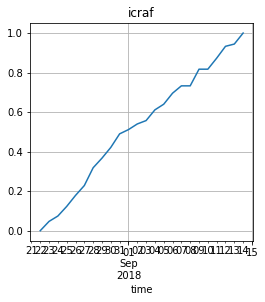

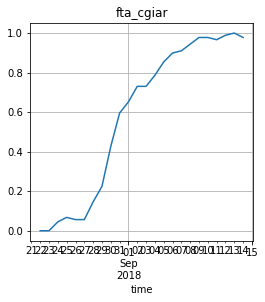

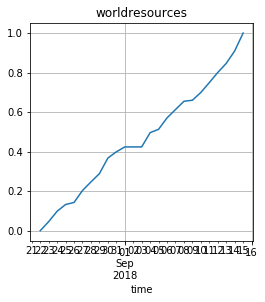

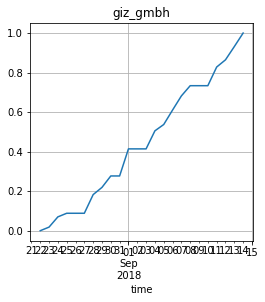

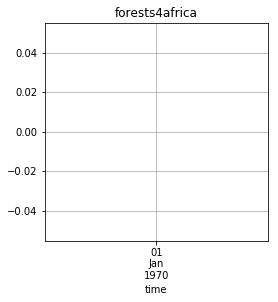

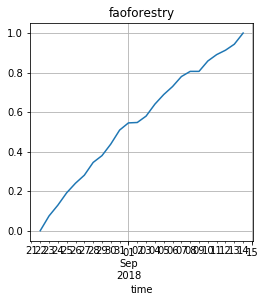

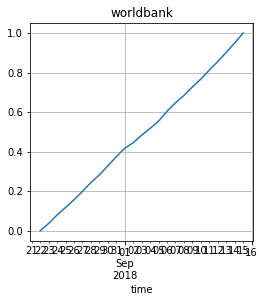

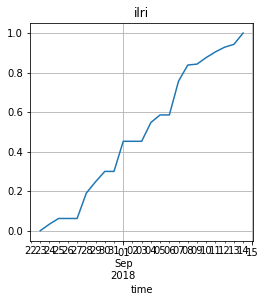

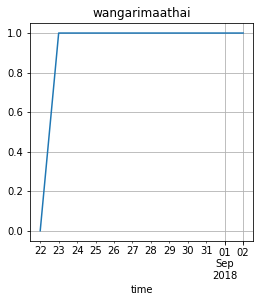

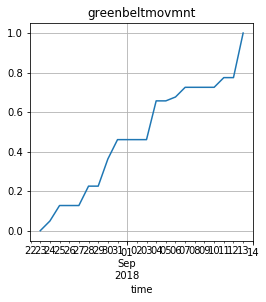

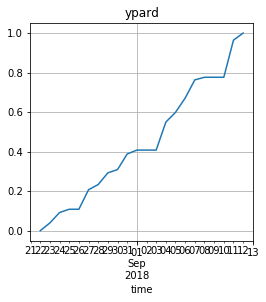

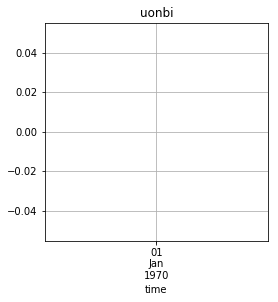

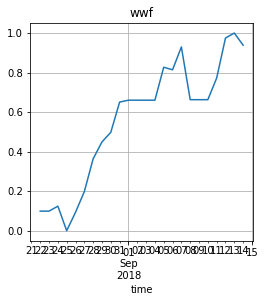

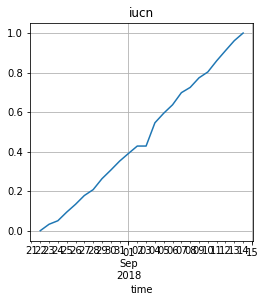

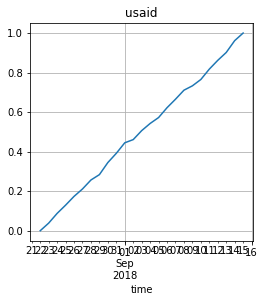

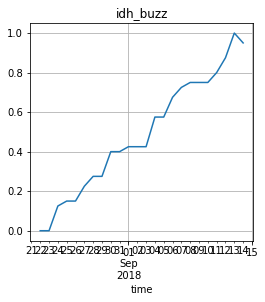

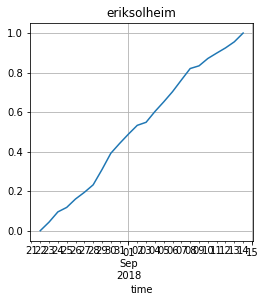

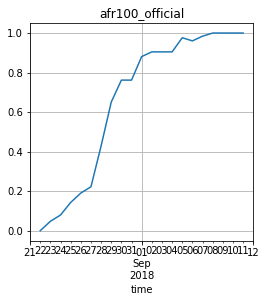

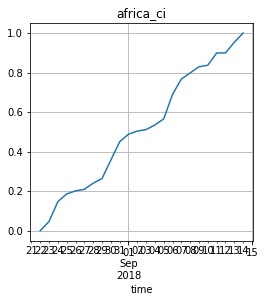

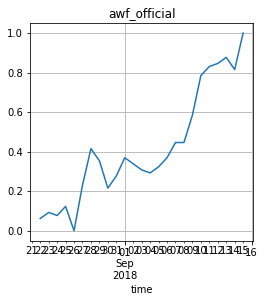

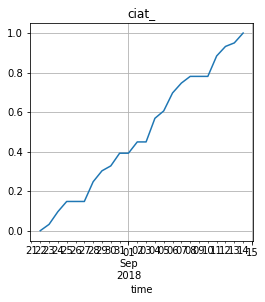

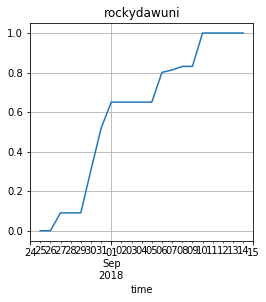

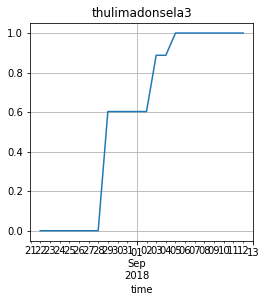

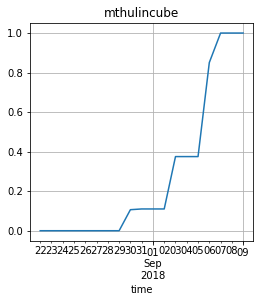

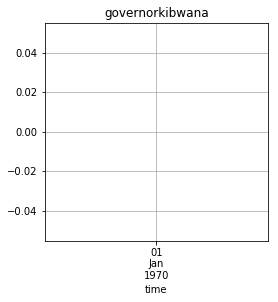

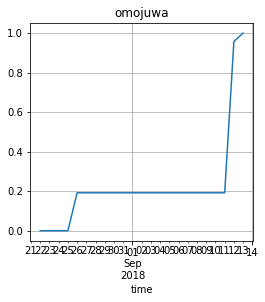

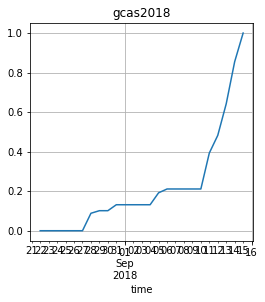

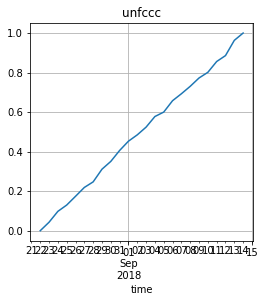

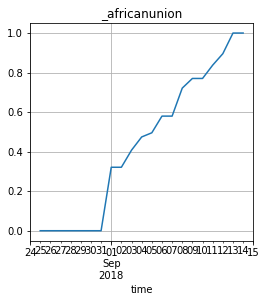

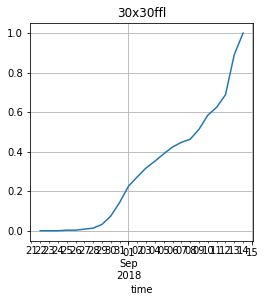

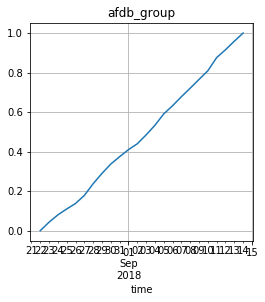

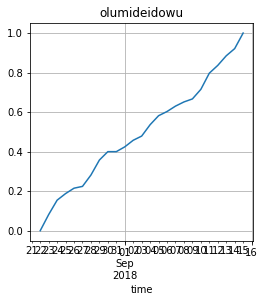

In [14]:
for u in target_users.keys():
    fig = plt.figure(figsize=(4,4))

    ax = plt.subplot(1,1, 1)
    left[u + "_norm"].plot(ax=ax)
    # left["olumideidowu"].plot(ax=ax)

    # ax.set_yscale("log")

    plt.title(u)
    plt.grid()
    plt.show()

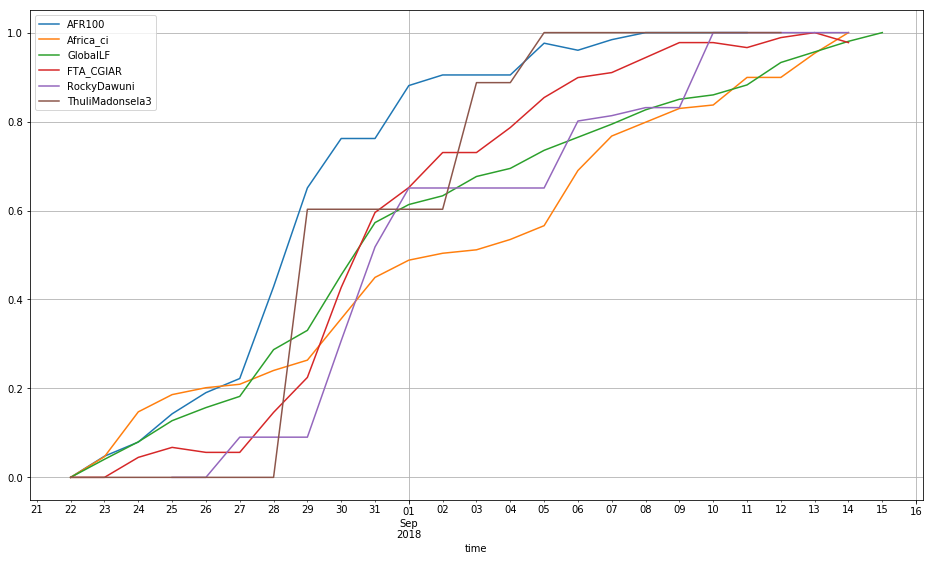

In [15]:
plot_targets = [
    "afr100_official",
    "africa_ci",
    "globallf",
    "fta_cgiar",
    "rockydawuni",
    "thulimadonsela3",
]

fig = plt.figure(figsize=(16,9))

ax = plt.subplot(1,1, 1)
left[[x + "_norm" for x in plot_targets]].rename(columns={
    "afr100_official_norm": "AFR100",
    "africa_ci_norm": "Africa_ci",
    "globallf_norm": "GlobalLF",
    "fta_cgiar_norm": "FTA_CGIAR",
    "rockydawuni_norm": "RockyDawuni",
    "thulimadonsela3_norm": "ThuliMadonsela3",
}).plot(ax=ax)
# left["olumideidowu"].plot(ax=ax)

# ax.set_yscale("log")

plt.grid()
plt.show()

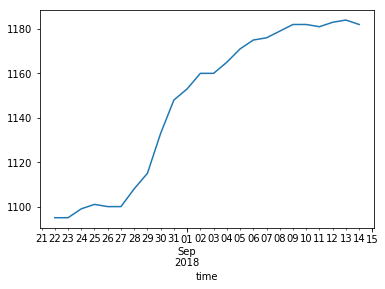

In [16]:
first["fta_cgiar"].plot()

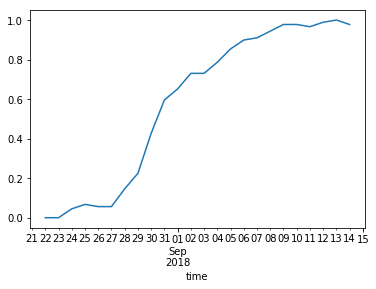

In [17]:
left["fta_cgiar_norm"].plot()

In [7]:
rdd = sc.textFile("wri/data/stream_*/*.gz")
all_tweets_ = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)
all_tweets = all_tweets_.map(lambda t: (t["id"], t)).reduceByKey(lambda l, r: l).map(lambda tup: tup[1]).cache()
all_tweets_count = all_tweets.count()

In [8]:
all_tweets_count

1064224

In [9]:
dates = all_tweets.map(lambda t: (t_to_d(t), 1)).reduceByKey(lambda l,r: l+r).collect()
date_df = pd.DataFrame(dates, columns=["date", "count"])
date_df.index = date_df.date

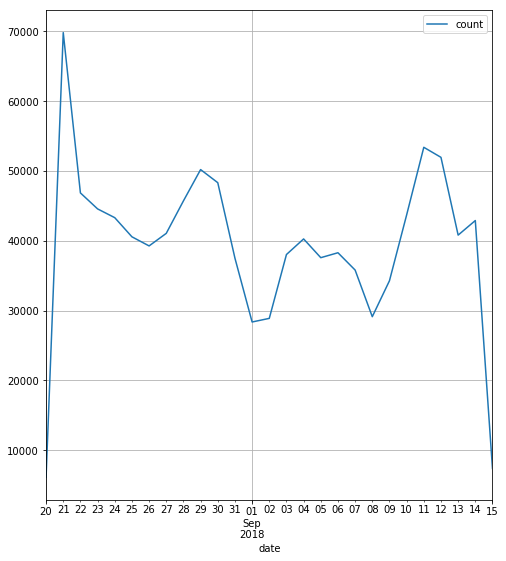

In [14]:
fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(1,1,1)
date_df.resample("D").sum().plot(ax=ax)

plt.grid()
plt.show()